SENTIMENT ANALYSIS

---

Il progetto consiste nella sentiment analysis di un dataset di poesie tratto dal Progetto Gutenberg. L'analisi è stata condotta in due modalità:


1.  Su frasi integrali
2.  Su frasi ridotte


Le frasi ridotte sono state ottenute attraverso un processo di tokenizzazione e selezione delle seguenti parti del discorso (POS): nomi, verbi, avverbi e aggettivi.

L’analisi del sentiment si è articolata nei seguenti passaggi:


*   Calcolo degli embeddings
*  Calcolo della similarità coseno

*   Individuazione della similarità massima

*  Assegnazione del sentiment

A ciascuna poesia del set di test è stato assegnato il sentiment della poesia più simile (in termini di similarità coseno) presente nel training set.

Infine, sono state calcolate le metriche di accuratezza e i risultati ottenuti sono stati visualizzati graficamente.


---
LIBRERIE

Sono state usate le seguenti librerie:



*   Pandas
*   NumPy
*   Sentence-Tranformers
*   SpaCy
*   MatplotLib
*   Scikit-learn












Primo step: autenticazione con kaggle per importare il *dataset*.

Segue caricamento del dataset
:

In [ ]:

# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

edqian_twitter_climate_change_sentiment_dataset_path = kagglehub.dataset_download('edqian/twitter-climate-change-sentiment-dataset')
elisascifo_sentiment_path = kagglehub.dataset_download('elisascifo/sentiment')

print('Data source import complete.')


Data source import complete.




Divisione del dataset in due parti: una per il train e una per il test e creazione dataframe tramite pandas.

90% train

10% test

Valori sentiment :

0 = negativo;

1 = positivo;

2 = no_impact;

3 = mixed


In [ ]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["test"])


Il dataset scelto proviene da huggingface ed è formato da poesie del progetto Gutenberg https://huggingface.co/datasets/google-research-datasets/poem_sentiment

Stampo il dataframe della sezione train

In [ ]:
df_train


,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3
...,...,...,...
887,887,to his ears there came a murmur of far seas be...,2
888,888,"the one good man in the world who knows me, --",1
889,889,faint voices lifted shrill with pain,0
890,890,"an', fust you knowed on, back come charles the...",2


Stampo il dataframe della parte da testare

In [ ]:
df_test


,id,verse_text,label
0,0,"my canoe to make more steady,",2
1,1,and be glad in the summer morning when the kin...,1
2,2,and when they reached the strait symplegades,2
3,3,she sought for flowers,2
4,4,"if they are hungry, paradise",2
...,...,...,...
99,99,shall live my highland mary.,2
100,100,now is past since last we met,2
101,101,begins to live,2
102,102,beneath the hazel bough;,2


Per eseguire l'analisi del sentiment, trasformo ogni frase in un vettore denso utilizzando un modello preaddestrato, quindi calcolo la similarità massima tra le frasi appartenenti ai due gruppi. A ciascuna frase del set di test viene assegnato il sentiment della frase più simile presente nel set di addestramento.


---


Importo la libreria *Sentence-Transformers* e il modello necessari per generare gli embedding. In particolare, utilizzo il modello preaddestrato 'all-mpnet-base-v2', noto per le sue buone prestazioni, la capacità di rappresentare frasi in modo accurato e il supporto multilingua.


In [ ]:

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

Calcolo gli embedding di ogni poesia accedendo alla colonna 'verse_text'.




---




*   Calcolo embeddings frasi training set



In [ ]:
embeddings_train = model.encode(list(df_train['verse_text']))
embeddings_train
#uso la funzione model.encode di sentence_transformers per rendere ogni frase un vettore
#ottengo come risultato un array bidimensionale numpy contenente gli embeddings vettoriali, dove ogni riga è un vettore e ogni colonna è una dimensione dell'embedding.

array([[ 0.03305687, -0.0074393 , -0.02632542, ...,  0.03078944,
        -0.02693794, -0.0436177 ],
       [-0.01784474,  0.03299818, -0.04278288, ..., -0.02349861,
         0.00836789,  0.00190935],
       [ 0.03101981,  0.00848335, -0.0139709 , ...,  0.01152052,
         0.00138114, -0.02790895],
       ...,
       [-0.00809903, -0.01897734,  0.01329882, ...,  0.07559277,
        -0.03978692, -0.00138425],
       [-0.0121388 ,  0.0195877 , -0.02053032, ...,  0.0355369 ,
        -0.02291702, -0.02082615],
       [-0.00688715,  0.09537993,  0.00138715, ...,  0.02563973,
         0.00780833, -0.00114112]], dtype=float32)

Calcolo gli embeddings delle poesie della sezione test



In [ ]:
embeddings_test = model.encode(list(df_test['verse_text']))

Importo il tool per calcolare la similarità tra gli embeddings usando cos_sim e argmax.

In [ ]:

from numpy import argmax
from sentence_transformers.util import cos_sim

Calcolo della similarità coseno tra ogni frase della sezione test e ogni frase della sezione train. La similarità ritorna una matrice quadrata dove le righe sono i valori di test e le colonne i valori di train.

Successivamente, viene applicata la funzione argmax lungo ciascuna riga della matrice: per ogni frase del test si individua l’indice della frase del training con la similarità più alta, ovvero la corrispondenza migliore. A questa frase viene quindi associato il relativo valore di sentiment.

In [ ]:
similarity = cos_sim(embeddings_test, embeddings_train) #fornisco come parametri le liste di embeddings dove ogni frase è un vettore
#similarity è una matrice bidimensionale (righe e colonne).La matrice di similarità avrà 104 righe e 892 colonne.
#Ogni riga della matrice rappresenta una frase del test, e ogni colonna rappresenta una frase del train.
print(similarity)

#Trovo per ogni frase df_test quella più simile in df_train con la funzione argmax --> per ogni vettore trova quello con similarità più alta, cioè il match miglore

best_match = similarity.argmax(dim=1)
print('Tensore con gli indici delle poesie train section più simili a ciascuna frase test section', best_match)
#dim = 1 -> analizza le righe della matrice cioè la sezione test.
#Restituisce l'indice della frase più simile per ciascuna frase
#Ottengo come risultato un tensore, cioè una struttura dati che rappresenta un array multidimensionale,
#contenente gli indici delle frasi del training set più simili a ciascuna frase del test. esempio tensor[0] ha valore 457 significa che la prima frase della sezione test è più simile alla n 457 di train.
#Stampo le coppie di frasi - la funzione .item() trasforma il tensore in numero
for i, tens in enumerate(best_match):
  frase_ass = tens.item() #dà l'indice numerico della frase più simile
  sim_score = similarity[i][frase_ass].item()  #prende il valore numerico della similarità specifica tra i (test) e frase_ass (train).
  print(f"Frase test: {df_test.iloc[i]['verse_text']}") #estrae il testo della frase corrispondente
  print(f"Frase match: Numero {frase_ass}, Testo: {df_train.iloc[frase_ass]['verse_text']} ")
  print(f"Similarità: {sim_score:.4f}")
  print('\n')
#.4 formatta il numero e mostra 4 cifre decimali

tensor([[0.1624, 0.3017, 0.2124,  ..., 0.0484, 0.0879, 0.0891],
        [0.3691, 0.2621, 0.4286,  ..., 0.2019, 0.3280, 0.4214],
        [0.1539, 0.1629, 0.1715,  ..., 0.1125, 0.2229, 0.0416],
        ...,
        [0.2087, 0.2534, 0.2319,  ..., 0.2509, 0.3048, 0.1591],
        [0.4831, 0.2250, 0.2853,  ..., 0.1206, 0.2252, 0.3520],
        [0.1803, 0.1330, 0.2961,  ..., 0.2490, 0.1814, 0.2728]])
Tensore con gli indici delle poesie train section più simili a ciascuna frase test section tensor([457, 168,  65, 808, 679, 381, 535,  35, 873, 158, 830, 150, 198, 173,
        151, 371,  97, 843, 328, 684, 331, 719,  98,  19, 100, 503, 436, 411,
        149, 374, 809, 404, 528,  80, 388, 284, 648,  18,  45,  12, 393, 556,
         73, 430, 416, 510, 726, 608, 717, 524, 809, 315, 371, 748, 546,  95,
        630,  52, 211, 370, 382, 401,  97, 444, 421,  87, 861, 470, 163, 528,
        219, 593, 103, 466, 387, 811, 721, 481, 843, 381,  71, 103, 137,  65,
        481, 269, 449, 799, 687, 115, 724, 

Aggiungo al dataframe test una colonna contenente per ogni poesia il sentiment predetto dal modello

In [ ]:

df_test['predicted_sentiment'] = [df_train.iloc[int(i)]['label'] for i in best_match] #iloc estrae l'etichetta corrispondente e l'assegna a ogni poesia
#Il sentiment corrisponde a quello dell'indice più simile nella sezione train
#Ogni i è un piccolo tensore che deve essere convertito in intero
#stampo il testo con il sentiment predetto e quello reale
df_test[['verse_text','predicted_sentiment', 'label']]


,verse_text,predicted_sentiment,label
0,"my canoe to make more steady,",2,2
1,and be glad in the summer morning when the kin...,0,1
2,and when they reached the strait symplegades,2,2
3,she sought for flowers,2,2
4,"if they are hungry, paradise",0,2
...,...,...,...
99,shall live my highland mary.,0,2
100,now is past since last we met,2,2
101,begins to live,2,2
102,beneath the hazel bough;,2,2


Conto quante poesie sono state classificate come positive, negative, miste o neutre.

Categorie sentiment :

 0 = negativo;

1 = positivo;


2 = no_impact;

 3 = mixed

In [ ]:
#uso la funzione di pandas '.value_counts()' per contare le serie
pr_counts = df_test['predicted_sentiment'].value_counts()
print('Conta dei sentiment predetti dal modello - sezione test-', pr_counts)
re_counts = df_test['label'].value_counts()
#stampo l'etichetta (0 = Negativo, etc) e il numero di testi associati a quel sentiment
print('Conta dei sentiment reali - sezione test-', re_counts)


Conta dei sentiment predetti dal modello - sezione test- predicted_sentiment
2    64
0    19
1    11
3    10
Name: count, dtype: int64
Conta dei sentiment reali - sezione test- label
2    69
0    19
1    16
Name: count, dtype: int64


Risultati ottenuti.


---


Calcolati:
Negativo 19;

Positivo 11;

No_impact 64;

Mixed 10.



---

Reali:

Negativo 19;

Positivo 16;

No_impact   69 ;


---


Si deduce che il modello è più performante nella categoria 'Negativo' e 'No_impact', mentre pecca maggiormente nella categoria 'Mixed'.


Calcolo le metriche di accuratezza con il tool *classification report* dalla libreria *sklearn* per vedere quante volte il modello ha predetto correttamente.




In [ ]:
#importo il tool dalla libreria
from sklearn.metrics import classification_report

Uso la funzione classification_report per calcolare le metriche di accuratezza dando come parametri la versione gold e quella predetta dal modello. Si tratta di una classificazione multiclasse (4 categorie) --> avremo una matrice di confusione 4x4

In [ ]:

print(classification_report(df_test['label'],df_test['predicted_sentiment']))
#mette a confronto i dati calcolati con quelli reali per misurare l'accuratezza del modello




              precision    recall  f1-score   support

           0       0.37      0.37      0.37        19
           1       0.55      0.38      0.44        16
           2       0.78      0.72      0.75        69
           3       0.00      0.00      0.00         0

    accuracy                           0.61       104
   macro avg       0.42      0.37      0.39       104
weighted avg       0.67      0.61      0.63       104



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Intepretazione metriche

---
Complessivamente è stata ottenuta un'accuratezza del 61%.--> proporzione di  predizioni corrette rispetto al totale. Nel nostro caso le classi sono poco bilanciate, quindi sarà a prescindere più bassa.


La recall è bassa nella classe 0 e 1, suggerendo che il modello perde una buona quantità di dati, non li riconosce.

La classe 2 è quella con performance migliore (precisione 78%, recall 72%, F1 75%), probabilmente perché è la più frequente (support 69). Ne ha riconosciuti 64 su 69.

Le classi 0 e 1 hanno risultati più bassi.

La classe 3 non ha esempi nel test (support=0), quindi non si può valutare.

La media macro è bassa (circa 0.4), indicando che sulle classi meno frequenti la performance è bassa.

La media weighted è più alta (intorno al 0.63) perché pesa di più la classe più numerosa.




Importo il tool da *matplotlib* per la visulizzazione grafica  della sentiment analysis sulla sezione test del dataset. Genero due grafici:
1. Rappresentazione dei dati ottenuti dal modello.
1. Rappresentazione dei dati reali (gold standard)


Si ricordano le classi usate:
0 = negativo;
1 = positivo;
2 = no_impact;
3 = mixed

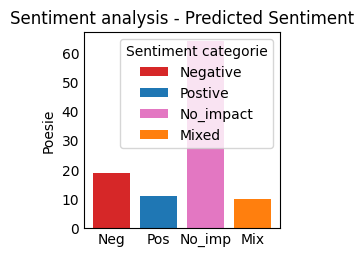

In [ ]:


import matplotlib.pyplot as plt


fig, ax = plt.subplots()

labels = ['Neg', 'Pos', 'No_imp', 'Mix']
counts = [19, 11, 64, 10]
bar_labels = ['Negative', 'Postive', 'No_impact', 'Mixed']
bar_colors = ['tab:red', 'tab:blue', 'tab:pink', 'tab:orange']

ax.bar(labels, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Poesie')
ax.set_title('Sentiment analysis - Predicted Sentiment')
ax.legend(title='Sentiment categorie')

plt.show()


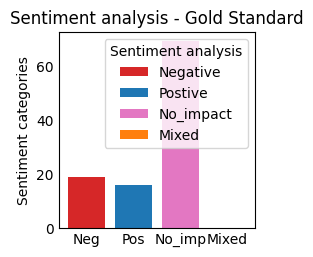

<Figure size 1000x600 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

labels = ['Neg', 'Pos', 'No_imp', 'Mixed']
counts = [19, 16, 69,0]
bar_labels = ['Negative', 'Postive', 'No_impact', 'Mixed']
bar_colors = ['tab:red', 'tab:blue', 'tab:pink', 'tab:orange']

ax.bar(labels, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Sentiment categories')
ax.set_title('Sentiment analysis - Gold Standard')
ax.legend(title='Sentiment analysis')
plt.figure(figsize=(10, 6))
plt.show()

Seconda parte.

---



Ripeto la sentiment analysis sulle frasi ridotte.

Effettuo la tokenizzazione dei testi per estrarre frasi formate da nomi, aggettivi, verbi e avverbi, utilizzando *spacy*.


Per la SA verrà usato lo stesso procedimento :


*   Calcolo degli embeddings
*   Calcolo della similarità massima


*   Per l'assegnazione del sentiment alle frasi della sezione train si attingerà al sentiment della frase integrale corrispondente.








Importo spacy per la tokenizzazione e l'estrazione delle POS  e json per la creazione dei file.



In [ ]:
import spacy
import json

Creo DataFrame per l'estrazione delle POS prendendo solo il testo ('verse_text') e poi creo un file json che contiene il DataFrame creato

In [ ]:
#creo df train frasi ridotte
df_train_tok = df_train['verse_text'] #estraggo il testo
#converto il df in file json usando la funzione di pandas '.to_json'
df_train_tok.to_json('dftr_tok.json', orient='values', lines=False, force_ascii=False)

orient = values -> in modo che ogni poesia sia una stringa; ottengo un array annidato, una lista di liste

force_ascii= False -> conserva i caratteri non-ASCII;

lines = False -> unico oggetto json dove ogni oggetto è su una riga.


Ripeto le operazioni di creazione datframe e file json con il testo delle poesie della sezione test


In [ ]:
#dataframe
df_test_tok = df_test['verse_text']
#conversione in file json
df_test_tok.to_json('dfte_tok.json', orient='values', lines=False, force_ascii=False)

Importo il modello per la tokenizzazione usando *spacy*.

Leggo il file json rendendolo una lista di stringhe con la funzione 'json-load()' e poi analizzo ciascuna frase al fine di estrarre le POS desiderate e generare nuove frasi formate dalle POS estratte.

In [ ]:
#carico il modello preaddestrato per l'inglese usando la funzione spacy.load()
nlp = spacy.load('en_core_web_sm')

#Leggo il file json
with open('dftr_tok.json', 'r', encoding='utf-8') as f:
    text_tr= json.load(f) #Lo rendo una lista di stringhe
#Creo lista dove salvare le nuove frasi
    frasi_tr_filtrate = []

# Filtro le POS desiderate
pos_desiderate = {'NOUN', 'VERB', 'ADJ', 'ADV'}

# Analizzo ciascuna frase -> per ogni frase della lista tokenizzo le parole e se corrispondono alle POS desiderate le salvo in una lista
for frase_text in text_tr:
  #Analizzo con nlp di Spacy che restituisce un oggetto doc, che rappresenta la frase processata linguisticamente
    doc_tr = nlp(frase_text) #itero su ciascuna frase una per volta e non su tutto il documento
    nuova_frase = ' '.join([token.text for token in doc_tr if token.pos_ in pos_desiderate]) #per ogni token in ogni frase, se il token è una delle POS richieste, tokenizza e aggiungi alla lista --> da oggetto a stringa
    #Prendo per ogni frase i token che corrispondono alle POS e li metto in una frase separati dallo spazio


    #Formo una lista con le nuove frasi ridotte
    frasi_tr_filtrate.append(nuova_frase)
# Mostro il risultato
for frase in frasi_tr_filtrate:
    print('Questa è una poesia ridotta',frase)
#ogni frase è stata trasformata iin una nuova frase composta da aggettivi, verbi, nomi e avverbi secondo il modello


Questa è una poesia ridotta pale blue berries peaceful shades--
Questa è una poesia ridotta flows so long falls rain
Questa è una poesia ridotta lonesome day
Questa è una poesia ridotta peruse conquered fame heroes victories mighty generals envy generals
Questa è una poesia ridotta inward strife truth liberty
Questa è una poesia ridotta red sword sealed vows
Questa è una poesia ridotta very venus pipe
Questa è una poesia ridotta man called brother
Questa è una poesia ridotta so on then worthless gaud
Questa è una poesia ridotta hide orb truth throne
Questa è una poesia ridotta call more urgent journeys slow
Questa è una poesia ridotta _ rabelais
Questa è una poesia ridotta match bend thorough blend colossal form face
Questa è una poesia ridotta played different countries
Questa è una poesia ridotta tells day ended
Questa è una poesia ridotta alone gold
Questa è una poesia ridotta has charmingly bourbon air
Questa è una poesia ridotta sounded sea blast war
Questa è una poesia ridotta ch

Ripeto lo stesso procedimento con il secondo file.

In [ ]:
# Leggo il file JSON
with open('dfte_tok.json', 'r', encoding='utf-8') as f:
    text_te= json.load(f) #la rendo una lista di stringhe

    frasi_te_filtrate = []

# Filtro le POS desiderate
pos_desiderate = {'NOUN', 'VERB', 'ADJ', 'ADV'}

# Analizzo ciascuna frase
for frase_text in text_te:
    doc_te = nlp(frase_text) #itero su ciascuna frase una per volta
    nuova_frase = ' '.join([token.text for token in doc_te if token.pos_ in pos_desiderate])
    frasi_te_filtrate.append(nuova_frase)

# Mostro il risultato
for frase in frasi_te_filtrate:
    print('Questa è una poesia ridotta',frase)
#Ogni frase è stata trasformata iin una nuova frase composta da aggettivi, verbi, nomi e avverbi secondo il modello

Questa è una poesia ridotta canoe make more steady
Questa è una poesia ridotta glad summer morning kindred ride way
Questa è una poesia ridotta reached strait symplegades
Questa è una poesia ridotta sought flowers
Questa è una poesia ridotta hungry paradise
Questa è una poesia ridotta indignantly hurled cry
Questa è una poesia ridotta house haunted
Questa è una poesia ridotta laying snow white flowers hair
Questa è una poesia ridotta long uncoupled bed childless eld
Questa è una poesia ridotta boulder strewn mountain crop
Questa è una poesia ridotta thine own bird sweet enthusiasm
Questa è una poesia ridotta said then lost arch angel seat
Questa è una poesia ridotta simple strain--
Questa è una poesia ridotta golden cross worn innermostly carved
Questa è una poesia ridotta such days thou even thou didst know
Questa è una poesia ridotta change mournful gloom
Questa è una poesia ridotta now o daughter kings let rise face day
Questa è una poesia ridotta penance saintly styrian monk
Questa



Calcolo gli embeddings di ciascuna frase ridotta della sezione test


In [ ]:
emb_te_red = model.encode(frasi_te_filtrate)

Calcolo gli embeddings di ciascuna frase ridotta della sezione test

In [ ]:
emb_tr_red = model.encode(frasi_tr_filtrate)

Calcolo la similarità tra gli embeddings delle frasi ridotte del training set e gli embeddings delle nuove frasi ridotte della sezione test


In [ ]:

similarity_red = cos_sim(emb_te_red, emb_tr_red)
similarity_red

tensor([[0.0350, 0.2906, 0.0630,  ..., 0.0210, 0.0476, 0.0819],
        [0.2434, 0.2049, 0.2636,  ..., 0.1503, 0.1574, 0.1878],
        [0.1656, 0.1089, 0.0909,  ..., 0.1128, 0.1339, 0.0652],
        ...,
        [0.0638, 0.2104, 0.1555,  ..., 0.1714, 0.1990, 0.0953],
        [0.3004, 0.1275, 0.2194,  ..., 0.0532, 0.2017, 0.2816],
        [0.1582, 0.1982, 0.1923,  ..., 0.2071, 0.1827, 0.1844]])

Creo un dataframe, con la funzione pd.DataFrame di Pandas, contenente le nuove frasi ottenute al fine della SA

In [ ]:
#Il df è formato da una colonna chiamata 'testo' che contiene le frasi ridotte
df_te_red = pd.DataFrame(frasi_te_filtrate, columns=['testo'])
df_te_red

,testo
0,canoe make more steady
1,glad summer morning kindred ride way
2,reached strait symplegades
3,sought flowers
4,hungry paradise
...,...
99,live highland
100,now past last met
101,begins live
102,hazel bough


Creo un dataframe per il train contenente le nuove frasi della sezione train e l'etichetta corrispondente (presa dal dataframe precedente)


In [ ]:
df_tr_red = pd.DataFrame({
    'frasi': frasi_tr_filtrate,
    'sentiment': df_train['label']
})
df_tr_red

,frasi,sentiment
0,pale blue berries peaceful shades--,1
1,flows so long falls rain,2
2,lonesome day,0
3,peruse conquered fame heroes victories mighty ...,3
4,inward strife truth liberty,3
...,...,...
887,ears there came murmur far seas wind,2
888,good man world knows,1
889,faint voices lifted shrill pain,0
890,fust knowed back come charles second,2


Ripeto le procedure di calcolo della similarità massima tra le frasi e assegnazione del sentiment

In [ ]:
best_match_red = (similarity.argmax(dim=1))
#dim = 1 -> analizza le righe della matrice cioè la sezione test

print('Tensore con gli indici delle poesie ridotte train section più simili a ciascuna frase ridotta test section', best_match_red)
#Restituisce l'indice della frase più simile
#Stampo i risultati ottenuti accedendo a ogni indice
for i, tens in enumerate(best_match_red):
  frase_associata = tens.item()
  sim_score_red = similarity_red[i][frase_associata].item()
  print(f"Frase test: {df_te_red.iloc[i]['testo']}")
  print(f"Frase match: Numero {frase_associata}, Testo: {df_tr_red.iloc[frase_associata]['frasi']} ")
  print(f"Similarità: {sim_score_red:.4f}")
  print('\n')

Tensore con gli indici delle poesie ridotte train section più simili a ciascuna frase ridotta test section tensor([457, 168,  65, 808, 679, 381, 535,  35, 873, 158, 830, 150, 198, 173,
        151, 371,  97, 843, 328, 684, 331, 719,  98,  19, 100, 503, 436, 411,
        149, 374, 809, 404, 528,  80, 388, 284, 648,  18,  45,  12, 393, 556,
         73, 430, 416, 510, 726, 608, 717, 524, 809, 315, 371, 748, 546,  95,
        630,  52, 211, 370, 382, 401,  97, 444, 421,  87, 861, 470, 163, 528,
        219, 593, 103, 466, 387, 811, 721, 481, 843, 381,  71, 103, 137,  65,
        481, 269, 449, 799, 687, 115, 724,  70, 655, 783, 272, 218, 128, 265,
        435, 891, 522, 831, 700, 268])
Frase test: canoe make more steady
Frase match: Numero 457, Testo: see boats nets lying shore paumanok quite still 
Similarità: 0.4197


Frase test: glad summer morning kindred ride way
Frase match: Numero 168, Testo: sorrowful day children set 
Similarità: 0.2072


Frase test: reached strait symplegades
Fr

Assegnazione del sentiment alle nuove frasi.


Aggiungo al nuovo Dataframe una nuova colonna 'predicted_sentiment' contenente il sentiment predetto dal modello usando la sezione train di riferimento

In [ ]:
#per ogni frase viene assegnata l'etichetta della frase più simile
df_te_red['predicted_sentiment'] = [df_tr_red.iloc[int(i)]['sentiment'] for i in best_match_red] #iloc estrae le etichette
#Prende il sentiment corrispondente per ogni indice con similarità massima all'altro indice.

df_te_red[['testo','predicted_sentiment']]
#stampo il testo con il sentiment predetto


,testo,predicted_sentiment
0,canoe make more steady,2
1,glad summer morning kindred ride way,0
2,reached strait symplegades,2
3,sought flowers,2
4,hungry paradise,0
...,...,...
99,live highland,0
100,now past last met,2
101,begins live,2
102,hazel bough,2


Conto quante poesie sono state classificate come positive, negative, miste o neutre usando il metodo di pandas '.value_counts'

In [ ]:
print(df_te_red['predicted_sentiment'].value_counts())

predicted_sentiment
2    64
0    19
1    11
3    10
Name: count, dtype: int64


Sono stati ottenuti i seguenti risultati:

Negativi: 19;

Positivi : 11;

No_impact: 64;

Mixed:10;


---


La sentiment analysis svolta sulle stesse frasi, ma ridotte (composte solo da nomi,aggettivi,verbi e avverbi) ha generato gli stessi risultati dell'analisi condotta sulle frasi integrali.

---


Calcolo le metriche di accuratezza del modello per ottenere maggiori informazione sulla performatività


In [ ]:
print(classification_report(df_test['label'],df_te_red['predicted_sentiment']))
#mette a confronto i dati calcolati con quelli reali per misurare l'accuratezza del modello

              precision    recall  f1-score   support

           0       0.37      0.37      0.37        19
           1       0.55      0.38      0.44        16
           2       0.78      0.72      0.75        69
           3       0.00      0.00      0.00         0

    accuracy                           0.61       104
   macro avg       0.42      0.37      0.39       104
weighted avg       0.67      0.61      0.63       104



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Interpretazione metriche

---


L'analisi mostra un'accuratezza del 61%. La classe 2 è quella dove il modello performa meglio , mentre nelle classi 1 e 3 si registrano valori più bassi.
Confrontando i dati ottenuti con quelli dell'analisi precedente emergono gli stessi risultati.


La riduzione grammaticale non migliora la performance, tuttavia, non causa differenze legate alla perdita di informazione linguistica. Le frasi ridotte contengono abbastanza informazione semantica da rappresentare il contenuto emotivo in modo simile a quello delle frasi complete.

Creo un grafico per visualizzare il sentiment predetto per ciasdcuna nuova frase del dataset test riusando matplotlib e numpy.

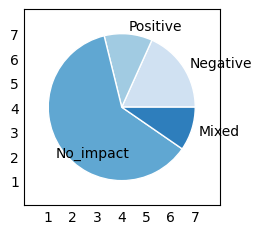

In [ ]:

import numpy as np

plt.style.use('_mpl-gallery-nogrid')


# make data
labels = ['Negative', 'Positive', 'No_impact', 'Mixed']
x = [19,11,64,10] #i valori ottenuti
#genera i colori
colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))

# plot
fig, ax = plt.subplots()
ax.pie(x,labels=labels, colors=colors, radius=3, center=(4, 4),
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True)

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()